In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uN1O0EDdiSuJbSsnD4bb")
project = rf.workspace("tpva").project("album-genre")
version = project.version(2)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Sampler, DataLoader

In [3]:
from unittest.mock import DEFAULT
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_dir = '/content/Album-Genre-2/train'
validation_dir = '/content/Album-Genre-2/valid'
test_dir = '/content/Album-Genre-2/test'

In [6]:
# Parameters
BATCH_SIZE = 50
IMG_SIZE = 224
NUM_WORKERS = 2

In [7]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


In [9]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [10]:
# Class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 14


In [11]:
#PRIMERO DE FELPA
class CNN:
    def __init__(self, outputs):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)

        for i in model.parameters():
            i.requires_grad = False

        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, outputs)
        )
        self.model = model

        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"
        self.model.to(self.device)
        self.parameters = model.parameters()


    def train(self, train_loader, val_loader, loss_fn, optimizer, epochs=10, patience=3):

        best_val_accuracy = 0.0
        early_stop_counter = 0

        for i in tqdm(range(0, epochs)):
            self.model.train()
            train_loss, correct_train = 0, 0
            for x, y in tqdm(train_loader):
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x)
                loss = loss_fn(outputs, y)
                #loss.backward()
                optimizer.step()
                train_loss += loss.item()
                correct_train += (outputs.argmax(1) == y).sum().item()

            train_accuracy = correct_train/len(train_loader.dataset)

            print(f"Epoch {i+1}, Training Loss: {train_loss / len(train_loader.dataset)}")
            print(f"Epoch {i+1}, Training Accuracy: {train_accuracy}")

            self.model.eval()
            val_loss, correct_val = 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    outputs = self.model(x)
                    loss = loss_fn(outputs, y)
                    val_loss += loss.item()
                    correct_val += (outputs.argmax(1) == y).sum().item()

            val_accuracy = correct_val/len(train_loader.dataset)
            print(f"Epoch {i+1}, Validation Loss: {val_loss / len(val_loader)}")
            print(f"Epoch {i+1}, Validation Accuracy {val_accuracy}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                print(f"No improvement for {early_stop_counter} epoch(s)")

            if early_stop_counter == patience:
                print(f"Early stopping triggered after {early_stop_counter} epochs")
                break

    def train_with_mini_batch(self, train_data, val_loader, loss_fn, optimizer, batch_size=32, epochs=10, patience=3, save_interval=1):
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        best_val_acc = 0.0
        early_stop_counter = 0

        for epoch in tqdm(range(0, epochs)):
            train_loss, correct_train = 0, 0

            indices = np.random.choice(len(train_data), size=batch_size, replace=False)
            batch_samples = [train_data[i] for i in indices]
            x, y = zip(*batch_samples)
            x = torch.stack([torch.tensor(img, dtype=torch.float32) for img in x])
            y = torch.tensor(y, dtype=torch.long)

            self.model.train()
            x, y = x.to(self.device), y.to(self.device)
            optimizer.zero_grad()
            outputs = self.model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            correct_train += (outputs.argmax(1) == y).sum().item()

            train_accuracy = correct_train/batch_size

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_accuracy)

            print()
            print(f"Epoch {epoch+1}, Training Loss: {train_loss}")
            print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy}")



            self.model.eval()
            val_loss, correct_val = 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    outputs = self.model(x)
                    loss = loss_fn(outputs, y)
                    val_loss += loss.item()
                    correct_val += (outputs.argmax(1) == y).sum().item()

            val_accuracy = correct_val/len(train_loader.dataset)

            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_accuracy)

            print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")
            print(f"Epoch {epoch+1}, Validation Accuracy {val_accuracy}")


                    # Save model every save_interval epochs
            if (epoch + 1) % save_interval == 0:
                model_filename = f"ResNet_{epoch+1}epochs_DATAAUG.pth"
                torch.save({'model_state_dict': self.model.state_dict()}, model_filename)
                print(f"Model saved as {model_filename}")

            # Early stopping logic
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                early_stop_counter = 0  # Reset counter if improvement
            else:
                early_stop_counter += 1
                print(f"No improvement for {early_stop_counter} epoch(s).")

            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        return history


    def forward(self, image):
        input_tensor = transforms.ToTensor()(image).unsqueeze(0)
        self.model.eval()
        input_tensor = input_tensor.to(self.device)

        with torch.no_grad():
            output = self.model(input_tensor)

        prediction = torch.argmax(output, dim=1).item()

        return prediction


    def get_parameters(self):
        return self.parameters

    def save(self):
        model_filename = f"resnet50_model"
        torch.save({'model_state_dict': self.model.state_dict()}, model_filename)

    def confusion_mat(self , data=val_loader):
        self.model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)


        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"F1 Score: {f1:.4f}")
        print(classification_report(all_labels, all_preds))


        conf_mat = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()



def prepare_cnn(outputs):

    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    for i in model.parameters():
        i.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, outputs),
        nn.Softmax(dim=1)
    )

    return model

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(outputs=num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.get_parameters(), lr=0.001)

# model.train(train_loader, val_loader, loss_fn, optimizer, epochs=10)
history = model.train_with_mini_batch(train_dataset, val_loader, loss_fn, optimizer, batch_size=32, epochs=20, patience=3, save_interval=1)

#model.save()

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1, Training Loss: 2.633697509765625
Epoch 1, Training Accuracy: 0.0625


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, Validation Loss: 2.6425242764609203
Epoch 1, Validation Accuracy 0.007268951194184839


  5%|▌         | 1/20 [00:03<01:06,  3.48s/it]

Model saved as ResNet_1epochs_DATAAUG.pth

Epoch 2, Training Loss: 2.572002649307251
Epoch 2, Training Accuracy: 0.125
Epoch 2, Validation Loss: 2.623550636427743
Epoch 2, Validation Accuracy 0.0071651090342679125


 10%|█         | 2/20 [00:06<01:02,  3.49s/it]

Model saved as ResNet_2epochs_DATAAUG.pth
No improvement for 1 epoch(s).

Epoch 3, Training Loss: 2.6145544052124023
Epoch 3, Training Accuracy: 0.125


 15%|█▌        | 3/20 [00:10<00:58,  3.45s/it]

Epoch 3, Validation Loss: 2.6138525179454257
Epoch 3, Validation Accuracy 0.007268951194184839
Model saved as ResNet_3epochs_DATAAUG.pth
No improvement for 2 epoch(s).

Epoch 4, Training Loss: 2.5342328548431396
Epoch 4, Training Accuracy: 0.21875


 20%|██        | 4/20 [00:13<00:53,  3.36s/it]

Epoch 4, Validation Loss: 2.6074240037373135
Epoch 4, Validation Accuracy 0.008203530633437175
Model saved as ResNet_4epochs_DATAAUG.pth

Epoch 5, Training Loss: 2.681692361831665
Epoch 5, Training Accuracy: 0.0625


 25%|██▌       | 5/20 [00:16<00:49,  3.28s/it]

Epoch 5, Validation Loss: 2.595758931977408
Epoch 5, Validation Accuracy 0.008411214953271028
Model saved as ResNet_5epochs_DATAAUG.pth

Epoch 6, Training Loss: 2.528456687927246
Epoch 6, Training Accuracy: 0.125


 30%|███       | 6/20 [00:20<00:45,  3.28s/it]

Epoch 6, Validation Loss: 2.5842515911374773
Epoch 6, Validation Accuracy 0.008203530633437175
Model saved as ResNet_6epochs_DATAAUG.pth
No improvement for 1 epoch(s).

Epoch 7, Training Loss: 2.648526906967163
Epoch 7, Training Accuracy: 0.0625


 35%|███▌      | 7/20 [00:23<00:42,  3.27s/it]

Epoch 7, Validation Loss: 2.5718680705342973
Epoch 7, Validation Accuracy 0.009138110072689512
Model saved as ResNet_7epochs_DATAAUG.pth

Epoch 8, Training Loss: 2.57625412940979
Epoch 8, Training Accuracy: 0.09375


 40%|████      | 8/20 [00:26<00:38,  3.24s/it]

Epoch 8, Validation Loss: 2.561938694545201
Epoch 8, Validation Accuracy 0.009553478712357217
Model saved as ResNet_8epochs_DATAAUG.pth

Epoch 9, Training Loss: 2.5445337295532227
Epoch 9, Training Accuracy: 0.0625


 45%|████▌     | 9/20 [00:29<00:35,  3.21s/it]

Epoch 9, Validation Loss: 2.5520206604685103
Epoch 9, Validation Accuracy 0.009968847352024923
Model saved as ResNet_9epochs_DATAAUG.pth

Epoch 10, Training Loss: 2.7080235481262207
Epoch 10, Training Accuracy: 0.0


 50%|█████     | 10/20 [00:32<00:31,  3.18s/it]

Epoch 10, Validation Loss: 2.5429321697780063
Epoch 10, Validation Accuracy 0.009968847352024923
Model saved as ResNet_10epochs_DATAAUG.pth
No improvement for 1 epoch(s).

Epoch 11, Training Loss: 2.4480762481689453
Epoch 11, Training Accuracy: 0.21875


 55%|█████▌    | 11/20 [00:35<00:28,  3.17s/it]

Epoch 11, Validation Loss: 2.5339540924344743
Epoch 11, Validation Accuracy 0.009657320872274144
Model saved as ResNet_11epochs_DATAAUG.pth
No improvement for 2 epoch(s).

Epoch 12, Training Loss: 2.690108060836792
Epoch 12, Training Accuracy: 0.0625


 55%|█████▌    | 11/20 [00:39<00:32,  3.56s/it]

Epoch 12, Validation Loss: 2.5258589131491527
Epoch 12, Validation Accuracy 0.009968847352024923
Model saved as ResNet_12epochs_DATAAUG.pth
No improvement for 3 epoch(s).
Early stopping triggered after 12 epochs.


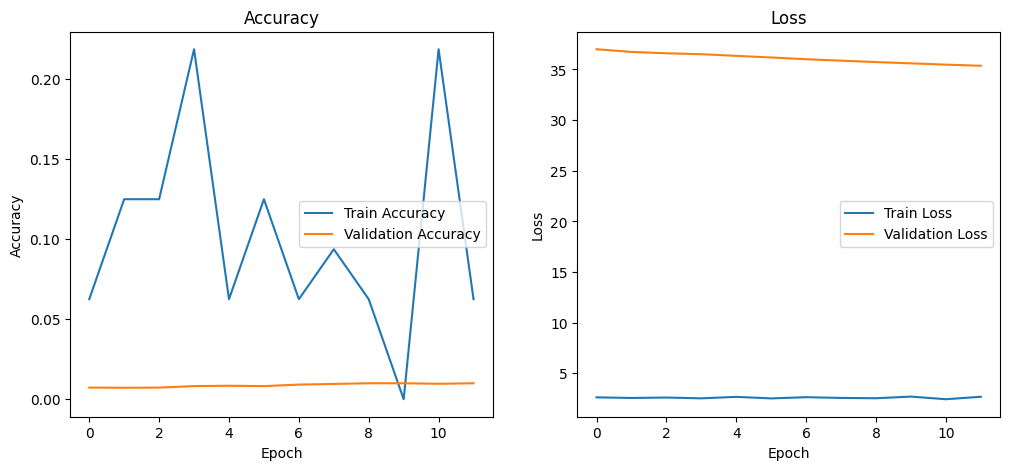

In [15]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

100%|██████████| 193/193 [00:40<00:00,  4.72it/s]
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


F1 Score: 0.0871
              precision    recall  f1-score   support

           0       0.12      0.52      0.19      1029
           1       0.18      0.47      0.26       906
           2       0.15      0.27      0.19      1062
           3       0.00      0.00      0.00       363
           4       0.23      0.04      0.06       774
           5       0.00      0.00      0.00       411
           6       0.13      0.06      0.08      1071
           7       0.00      0.00      0.00       330
           8       0.00      0.00      0.00       501
           9       0.29      0.02      0.04       963
          10       0.00      0.00      0.00       411
          11       0.00      0.00      0.00       411
          12       0.00      0.00      0.00       357
          13       0.14      0.01      0.02      1041

    accuracy                           0.14      9630
   macro avg       0.09      0.10      0.06      9630
weighted avg       0.12      0.14      0.09      9630



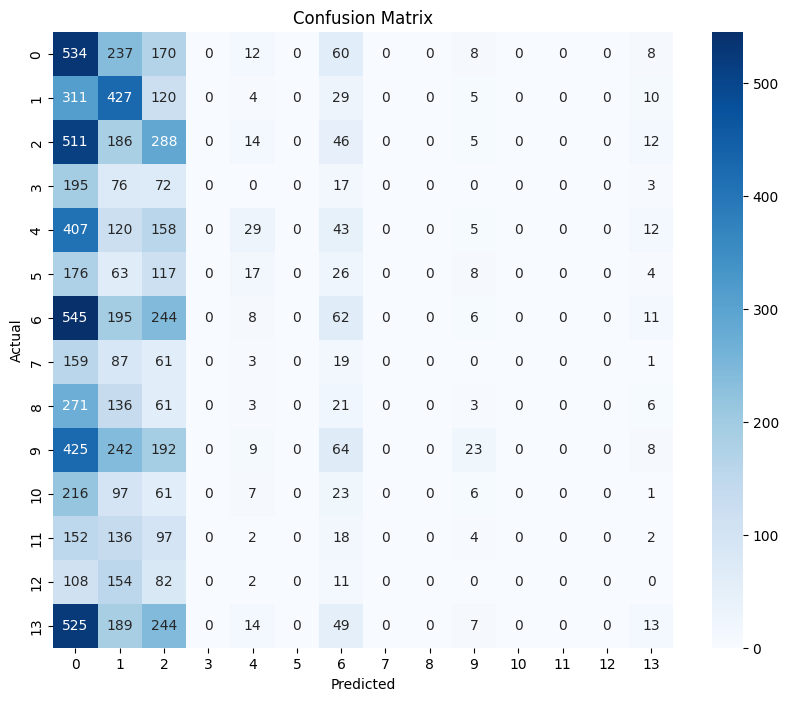

In [16]:
model.confusion_mat(train_loader)

100%|██████████| 14/14 [00:02<00:00,  5.23it/s]
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


F1 Score: 0.0828
              precision    recall  f1-score   support

           0       0.13      0.51      0.20        76
           1       0.16      0.44      0.24        62
           2       0.15      0.29      0.20        77
           3       0.00      0.00      0.00        25
           4       0.20      0.05      0.08        56
           5       0.00      0.00      0.00        26
           6       0.09      0.06      0.07        66
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        43
           9       0.00      0.00      0.00        75
          10       0.00      0.00      0.00        26
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        23
          13       0.12      0.01      0.02        79

    accuracy                           0.14       687
   macro avg       0.06      0.10      0.06       687
weighted avg       0.09      0.14      0.08       687



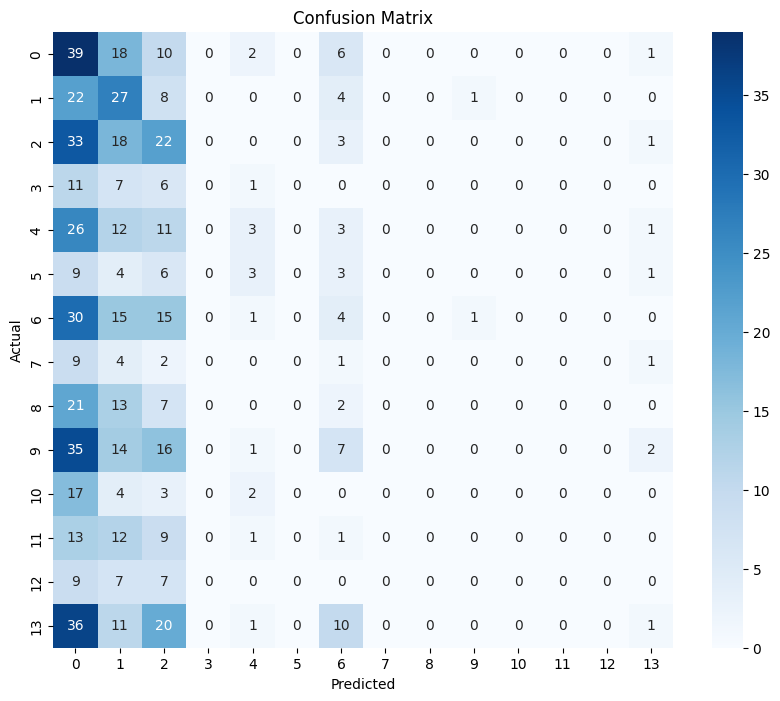

In [17]:
model.confusion_mat()

100%|██████████| 14/14 [00:03<00:00,  4.20it/s]
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


F1 Score: 0.0902
              precision    recall  f1-score   support

           0       0.13      0.45      0.20        80
           1       0.15      0.42      0.22        66
           2       0.17      0.35      0.23        69
           3       0.00      0.00      0.00        27
           4       0.20      0.06      0.10        47
           5       0.00      0.00      0.00        26
           6       0.06      0.04      0.05        77
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        39
           9       0.50      0.04      0.07        83
          10       0.00      0.00      0.00        31
          11       0.00      0.00      0.00        29
          12       0.00      0.00      0.00        16
          13       0.09      0.01      0.02        74

    accuracy                           0.14       688
   macro avg       0.09      0.10      0.06       688
weighted avg       0.14      0.14      0.09       688



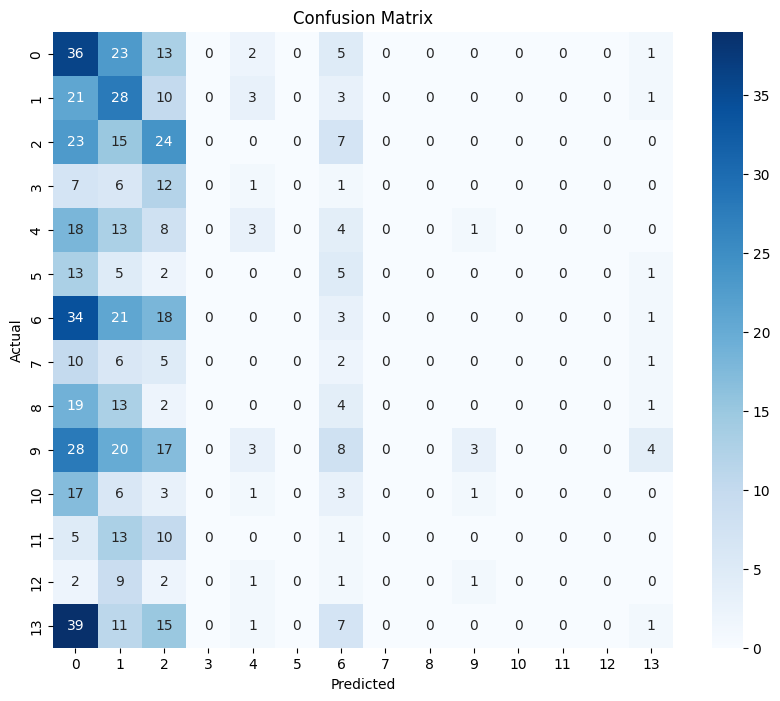

In [18]:
model.confusion_mat(test_loader)